# Monge, Bregman and Occam

## The Monge Problem

The Monge Problem delves into identifying, among all possible mappings $T: \mathbb{R}^d \to \mathbb{R}^d$ that push-forward a measure $\mu \in \mathcal{P}\left(\mathbb{R^d}\right)$
onto $\nu \in \mathcal{P}\left(\mathbb{R^d}\right)$, and using a cost function $c(x, y)$ as a measure of the length of the displacement, the most efficient maps. These optimal mappings are characterized as follows:  
$$T^\star := \underset{T\#\mu=\nu }{\arg \inf}\int_{\mathbb{R^d}}^{} c(x, T(x))d\mu$$.

## Sparsity inducing costs
Considering a translation-invariant cost function $c(x, y) := h\left(x-T(x)\right)$, we will shed the light on particular cost functions that can induce sparse transportations, ie $\left\|\Delta(x)  \right\|_0 \ll  d$ where $\Delta(x) := x-T(x)\in \mathbb{R}^d$ is the displacement vector.

Elastic costs are functions of the form $c(x, y) = h_\tau(x - y)$ with $h_\tau(z) = \frac{1}{2} \left\|z\right\|_2^2 + \tau(z)$. $\tau$ is a regularizer that, generally speaking, can be any regularizer as long as its proximal operator is known in closed form. Among these regularizers, we will study the l1 norm and show its sparsity inducing proprieties using OTT-JAX.

### First, let's import what we need

In [6]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [7]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import ott
from tqdm import tqdm
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.geometry.costs import ElasticSTVS, ElasticL1, ElasticL2, ElasticSqKOverlap, SqEuclidean
from ott.tools.gaussian_mixture import (
    gaussian_mixture,
)
from ott.tools import sinkhorn_divergence

### And let's control the randomness

In [8]:
rng = jax.random.PRNGKey(0)

## 1. Synthetic experiment

We start first by testing the estimator on a synthetic dataset. This dataset will be made of :
-  a source distribution that is made of a gaussian mixture of d multivariate normal distribution, also of dimension d. All of these distribution will have a zero mean and identically distributed components, except for the $i^{th}$ component that will have a positive mean and a lower variance.
- a target distribution sampled from a multivariate normal distribution of dimension d where the components are independent and identically distributed.

### 1.1. Generation of the data

In [9]:
def make_distribution_generators(d):
    # Source distribution, a simple gaussian points cloud
    mean_generator0 = jnp.zeros((1,d))
    cov_generator0 = jnp.array(
        [
            jnp.diag(jnp.full((d,), 0.2)),
        ]
    )
    weights_generator0 = jnp.ones((1,))

    gm_generator0 = (
        gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
            mean=mean_generator0,
            cov=cov_generator0,
            component_weights=weights_generator0,
        )
    )

    # Target distribution, a gaussian mixture that will envelope all the 
    # positive sides of the source distribution
    mean_generator1 = jnp.diag(jnp.full((d,), 2.0))
    cov_generator1 =  jnp.fill_diagonal(jnp.array(
        [
        jnp.diag(jnp.full((d,), 0.2)) for i in range(d)
        ]
    ), 0.05, inplace=False)
    weights_generator1 = jnp.ones((d,))


    gm_generator1 = (
        gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
            mean=mean_generator1,
            cov=cov_generator1,
            component_weights=weights_generator1,
        )
    )
    return gm_generator0, gm_generator1

To get a feel of what we generate, let's visualize what it looks like in two dimensions.

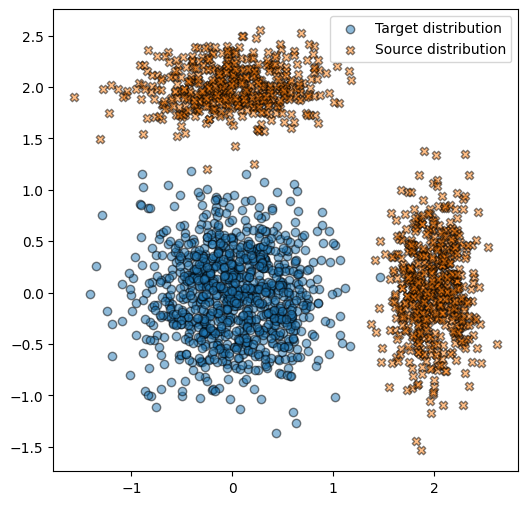

In [10]:
d = 2
gm_generator0, gm_generator1 = make_distribution_generators(d)

N = 1000
rng, rng1, rng2 = jax.random.split(rng, num=3)
x = gm_generator0.sample(rng=rng1, size=N)
y = gm_generator1.sample(rng=rng2, size=N)

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", alpha=0.5, label="Target distribution")
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", alpha=0.5, label="Source distribution")
plt.legend()
plt.show()

### 1.2. Sparse maps

Now, let's compare the sparsity and the $l_2^2$ Sinkhorn divergence of the standard entropic map (i.e. using the $l_2^2$ norm), and some sparsity inducing functions as the regularizer $\tau$: the  1-norm $l_1$, the Vanishing Shrinkage STVS and the $k$-Overlap. We will try different scalings for these regularizers and see how they behave.

In [11]:
solver = jax.jit(sinkhorn.Sinkhorn())
def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [12]:
def compute_sinkhorn_divergence(x, y):
  return sinkhorn_divergence.sinkhorn_divergence(pointcloud.PointCloud, x, y, cost_fn=SqEuclidean()).divergence

In [13]:
# different dimensions
supp_d = [8, 20, 100]

costs_fns = {
    "l2": lambda x: SqEuclidean(),
    "elastic_l1": ElasticL1,
    "tau_stvs": ElasticSTVS,
    "ovk_5": lambda x: ElasticSqKOverlap(5, scaling_reg=x),
    "ovk_7": lambda x: ElasticSqKOverlap(7, scaling_reg=x)
    }

res = {
    d: {
        "sparsity": {k: [] for k in costs_fns.keys()},
        "sink_div": {k: [] for k in costs_fns.keys()}
        } for d in supp_d
    }

In [14]:
N = 1000
n_points = 30
supp_reg = np.logspace(-2, 1, n_points)

for d in supp_d:
    gmm_generator0, gmm_generator1 = make_distribution_generators(d)
    y = gmm_generator0.sample(rng=rng1, size=N)
    x = gmm_generator1.sample(rng=rng2, size=N)
    new = gmm_generator1.sample(rng=rng, size=N)
    for cost_name, cost_fn in tqdm(costs_fns.items()):
        for reg in supp_reg:
            map = entropic_map(x, y, cost_fn(reg))
            res[d]["sparsity"][cost_name].append(((new - map(new)) < 1e-6).mean())
            res[d]["sink_div"][cost_name].append(compute_sinkhorn_divergence(map(new), y))
            if cost_name == "l2": # only compute l2 once
                res[d]["sparsity"]["l2"] = res[d]["sparsity"]["l2"] * n_points
                res[d]["sink_div"]["l2"] = res[d]["sink_div"]["l2"] * n_points
                break

100%|██████████| 5/5 [1:05:09<00:00, 781.96s/it] 


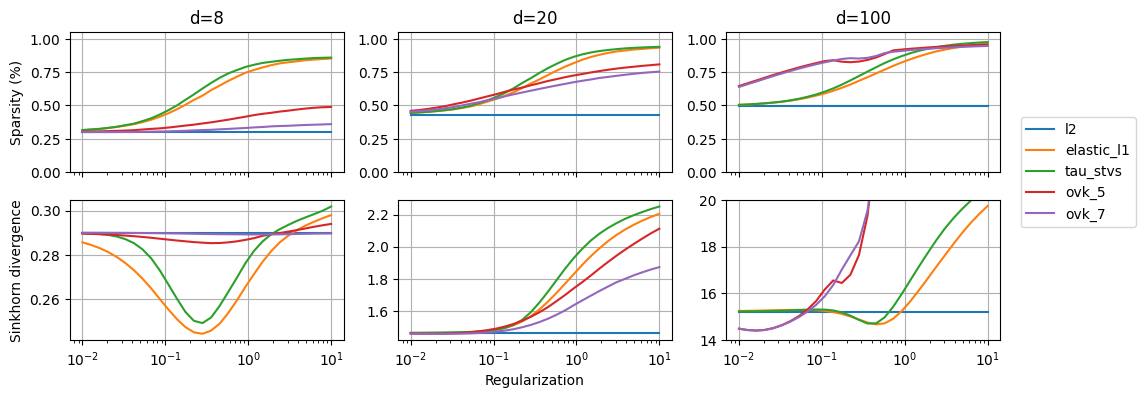

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 4), sharex=True)
for i, d in enumerate(supp_d):
    for cost_name, sparsity in res[d]["sparsity"].items():
        ax[0,i].plot(supp_reg, sparsity, label=cost_name)
    ax[0,i].set_xscale("log")
    ax[0,i].set_title(f"d={d}")
    ax[0,i].set_ylim(0, 1.05)
    ax[0,i].grid("on")
    for cost_name, sink_div in res[d]["sink_div"].items():
        ax[1,i].plot(supp_reg, sink_div, label=cost_name)
    ax[1,i].set_xscale("log")
    ax[1,i].grid("on")
ax[0,2].legend(bbox_to_anchor=(1.05, 0), loc='center left')
ax[1,2].set_ylim(14, 20)
ax[0,0].set_ylabel("Sparsity (%)")
ax[1,0].set_ylabel("Sinkhorn divergence")
ax[1,1].set_xlabel("Regularization")
plt.show()

We can observe on these plots that the elastic costs have the power to lead to much sparser maps than the standard cost and they may also have the capacity to make better maps in the sense of the the $l_2^2$ Sinkhorn divergence.

## 2. Application on a real dataset

We have chosen to employ the OCAM estimator on genomic data. This data was extracted from the Microarray Expression files for dataset GSE6008 sourced from the GEO database, focusing specifically on patients with Ovarian Tumors (data source: https://sbcb.inf.ufrgs.br/cumida). Our objective is to compare the distributions of genetic data between patients diagnosed with tumors and those deemed healthy. This dataset has few samples and a lot of features so we will proceed to dimensionality reduction and oversampling.

### Some new imports

In [ ]:
!pip install scanpy

In [17]:
from imblearn.over_sampling import SMOTE
import scanpy as sc
import pandas as pd

### Let's download the data and load it

In [ ]:
!gdown 1lFpZKgVsp9tkNKtCzGB3tzdsV1xBIJCH
!gdown 1bgsTib_XmssK25oBb3LOSbI1dEIARv6j
!gdown 1AGPmD1jNlVBSyf-BysE-lXX9LUUQhI_1

In [21]:
# Load data
source_data = pd.read_csv('/content/train.csv', index_col=0)
source_test_data = pd.read_csv('/content/test.csv', index_col=0)
target_data = pd.read_csv('/content/ovary_normal.csv', index_col=0)
target_data.reset_index(inplace=True)
print(source_data.shape, source_test_data.shape, target_data.shape)

(78, 22285) (20, 22285) (4, 22284)


In [22]:
source_data["type"].value_counts()

Ovarian_Tumor_Serous          33
Ovarian_Tumor_Endometrioid    29
Ovarian_Tumor_Mucinous        10
Ovarian_Tumor_ClearCel         6
Name: type, dtype: int64

In [23]:
target_data["type"].value_counts()

Ovary_Normal    4
Name: type, dtype: int64

### 2.1 Using Scanpy to reduce dimensionality

Before delving into our application, we employ Scanpy for dimensionality reduction. This step is crucial for handling the vast number of features in genomic data effectively. By selecting highly variable genes, we aim to capture the most relevant information while mitigating noise from the dataset.

In [24]:
full_data = pd.concat([source_data.drop("samples", axis=1), target_data])
tumor_types = full_data["type"].ravel()
features = full_data.drop(['type'], axis=1)
features.fillna(value=0, inplace=True)
adata = sc.AnnData(features)

# Perform feature selection (e.g., highly variable genes selection)
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
top_feature_indices = adata.var_names[adata.var['highly_variable']]
features_top = features.loc[:, top_feature_indices]
X_test = source_test_data.loc[:, top_feature_indices]

/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### 2.2 Data Augmentation with Smote

Given the limited size of our dataset, we employ SMOTE to address this challenge effectively. By synthetically generating new samples, we significantly increase the size of our dataset. This augmentation strategy is vital for ensuring that our models have sufficient data to learn from, particularly in scenarios where the original dataset is sparse. By expanding the dataset, we aim to enhance the robustness and generalization capabilities of our models, thereby improving their performance on unseen data.

We aim to increase our dataset to 400 samples, with half representing tumors and the other half representing healthy cells.

In [25]:
# Define sampling strategy for SMOTE
sampling_strategy = {
    'Ovarian_Tumor_Mucinous': 50,
    'Ovarian_Tumor_ClearCel': 50,
    'Ovarian_Tumor_Endometrioid': 50,
    'Ovarian_Tumor_Serous' : 50,
    'Ovary_Normal' : 200,
}

# Instantiate SMOTE with sampling strategy and adjust k_neighbors
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=2)

# Apply SMOTE to resample the data
X_train_resampled, y_train_resampled = smote.fit_resample(features_top, tumor_types)

# Create complete data
complete_data = X_train_resampled.copy()
complete_data["type"] = y_train_resampled

# Separate source and target data
source_data = complete_data[complete_data["type"] == "Ovary_Normal"].drop("type", axis=1)
target_data = complete_data[complete_data["type"] == "Ovarian_Tumor_Mucinous"].drop("type", axis=1)

# Assign to variables X and y
x = source_data.values
y = target_data.values
x_test = X_test.values

/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### 2.3 Estimator OCAM

With the preprocessed data in hand, we proceed to estimate the parameters of the OCAM (Optimal Transport and Clustering Algorithm for Multiple datasets) model. Leveraging different cost functions and regularization techniques, we aim to find the optimal configuration that minimizes Sinkhorn Divergence. This step is crucial for accurately aligning the distributions of genetic data between healthy and tumor samples.

In [26]:
d = 10000
s = 100
n_points = 50

solver = jax.jit(sinkhorn.Sinkhorn())

supp_d = [10_000]

costs_fns = {
    "l2": lambda x: SqEuclidean(),
    "elastic_l1": ElasticL1,
    "tau_stvs": ElasticSTVS
    }


res = {
    "elastic_l1": [],
    "l2": [],
    "tau_stvs": []
}

cancer_types = [
    "Ovarian_Tumor_Mucinous",
    "Ovarian_Tumor_ClearCel",
    "Ovarian_Tumor_Endometrioid",
    "Ovarian_Tumor_Serous"]

res = {
     c : {d: {
        "sparsity": {k: [] for k in costs_fns.keys()},
        "sink_div": {k: [] for k in costs_fns.keys()},
    }
    for d in supp_d} 
     for c in cancer_types
}

In [34]:
for c in cancer_types:
    target_data = complete_data[
        complete_data["type"] == c
    ].drop("type", axis=1)
    y = target_data.values
    for cost_name, cost_fn in tqdm(costs_fns.items()):
        for reg in np.logspace(-2, 2, n_points):
            cost = pointcloud.PointCloud(x, y, cost_fn=cost_fn(reg))
            prob = linear_problem.LinearProblem(cost)
            out = solver(prob)
            dual_potentials = out.to_dual_potentials()

            map = entropic_map(x, y, cost_fn(reg))
            sk_d = compute_sinkhorn_divergence(map(x_test), x_test)
            
            res[c][d]["sparsity"][cost_name].append(
                        ((x_test - map(x_test)) < 1e-6).mean()
                    )
            res[c][d]["sink_div"][cost_name].append(
                        compute_sinkhorn_divergence(map(x_test), y)
                    )

100%|██████████| 3/3 [31:33<00:00, 631.07s/it]


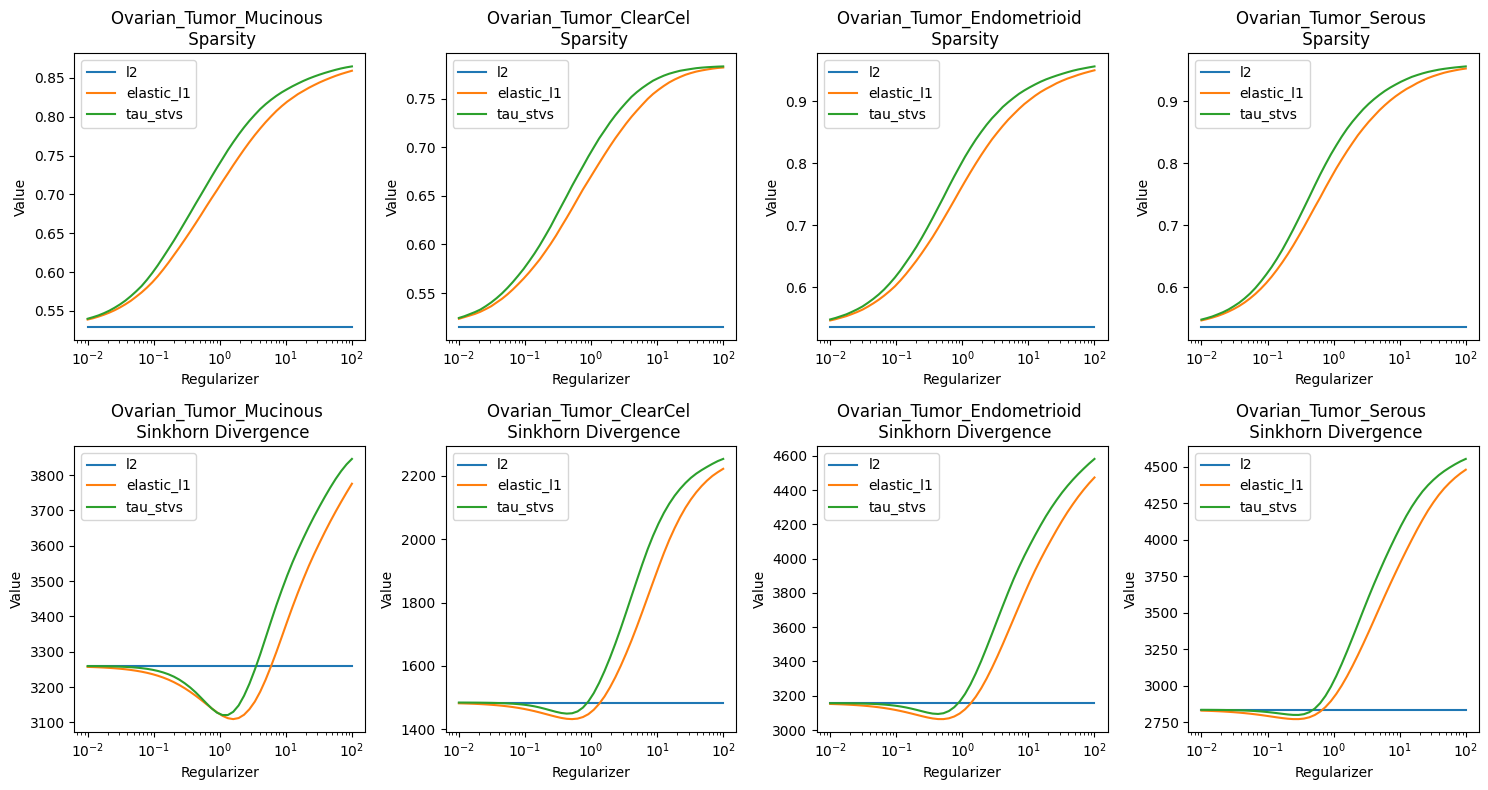

In [48]:
# Define the number of rows and columns in the grid
num_rows = 2
num_cols = len(cancer_types)

# Create a figure and axes for the grid of plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Iterate over each cancer type and plot the data
for i, cancer_type in enumerate(cancer_types):
    # Plot sparsity data
    axs[0, i].set_title(f"{cancer_type} \n Sparsity")
    for cost_name in costs_fns.keys():
        axs[0, i].plot(np.logspace(-2, 2, n_points), res[cancer_type][d]["sparsity"][cost_name], label=cost_name)
    axs[0, i].legend()
    axs[0, i].set_xscale('log')  # Set x scale to logarithmic

    # Plot Sinkhorn divergence data
    axs[1, i].set_title(f"{cancer_type} \n Sinkhorn Divergence")
    for cost_name in costs_fns.keys():
        axs[1, i].plot(np.logspace(-2, 2, n_points), res[cancer_type][d]["sink_div"][cost_name], label=cost_name)
    axs[1, i].legend()
    axs[1, i].set_xscale('log')  # Set x scale to logarithmic

# Set common labels for x and y axes
for ax in axs.flat:
    ax.set_xlabel('Regularizer')
    ax.set_ylabel('Value')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The plot illustrates that we can select a particular value of the regularizer to minimize the Sinkhorn Divergence. Additional tests can be conducted by adjusting the number of retained features and the quantity of samples added. Utilizing more authentic data rather than relying solely on artificial data augmentation could potentially enhance the outcomes.